In [1]:
from __future__ import division, print_function
import numpy as np
from random import randint
%matplotlib inline
import matplotlib.pylab as plt
import matplotlib.path as mplpath
from matplotlib.patches import Polygon
from matplotlib.patches import Arc, Arrow, Circle, CirclePolygon, Ellipse, Rectangle, Wedge
from keras.preprocessing import image

from learning2learn.images import rearrange_points

Using TensorFlow backend.


In [2]:
def generate_random_shape(x_min, x_max, y_min, y_max, edge_distance):
    """

    :param x_min:
    :param x_max:
    :param y_min:
    :param y_max:
    :param x_offset:
    :param y_offset:
    :return:
    """
    # Sample a number of points for the polygon
    nb_points = randint(3, 10)
    # 4 'types' of points; determines the edge that the point will be near
    point_types = ['left','right','top','bottom'] 
    # Cycle through drawing points of different types
    points = []
    for i in range(nb_points):
        if point_types[i%4] in ['left', 'right']:
            x = np.random.uniform(0, edge_distance)
            y = np.clip(
                np.random.normal(loc=(y_max-y_min)/2, scale=(y_max-y_min)/8), 
                y_min, 
                y_max
            )
            if point_types[i%4] == 'right':
                x = x_max - x
        elif point_types[i%4] in ['top', 'bottom']:
            x = np.clip(
                np.random.normal(loc=(x_max-x_min)/2, scale=(x_max-x_min)/8), 
                x_min, 
                x_max
            )
            y = np.random.uniform(0, edge_distance)
            if point_types[i%4] == 'bottom':
                y = y_max - y
        points.append((x, y))
    # Rearrange the points so that they are in the correct order
    points = rearrange_points(points)  
#     # Now center the points by computing the mean distance
#     # from the center and then subtracting this mean
#     x_mean = np.mean([p[0] - (x_max-x_min)/2 for p in points])
#     y_mean = np.mean([p[1] - (y_max-y_min)/2 for p in points])
#     points = [(p[0]-x_mean, p[1]-y_mean) for p in points]
    
    return points

In [3]:
def get_gradient(height, width, color, gradient=None):
    img = np.zeros(shape=(height, width, 3))
    if gradient is None:
        # no gradient mask
        for i in range(height):
            for j in range(width):
                img[i,j] = color
    elif gradient is 'right':
        # rightward gradient mask
        for i in range(height):
            for j in range(width):
                img[i,j] = color*(j/width)
    elif gradient is 'left':
        # leftward gradient mask
        for i in range(height):
            for j in range(width):
                img[i,j] = color*(1 - j/width)
    elif gradient is 'up':
        # upward gradient mask
        for i in range(height):
            for j in range(width):
                img[i,j] = color*(1 - i/height)
    elif gradient is 'down':
        # downward gradient mask
        for i in range(height):
            for j in range(width):
                img[i,j] = color*(i/height)
    else:
        raise Exception("'gradient' must be one of ['right', 'left', 'up', or 'down'].")
    
    return img

def get_gradient1(height, width, color, shape, gradient=None):
    assert gradient in ['left', 'right', 'up', 'down', None]
    # initialize image and mask
    img = np.zeros(shape=(height, width, 3))
    mask = np.ones(shape=(height, width, 3))
    # find box window of the shape
    x_min = int(min([s[0] for s in shape]))
    x_max = int(max([s[0] for s in shape]))
    y_min = int(min([s[1] for s in shape]))
    y_max = int(max([s[1] for s in shape]))
    dx = x_max - x_min
    dy = y_max - y_min
    # Step through and determine mask at each pixel
    # in our shape window
    for i in range(dy):
        for j in range(dx):
            if gradient == 'right':
                mask[y_min+i, x_min+j] = j/dx
            elif gradient == 'left':
                mask[y_min+i, x_min+j] = 1 - j/dx
            elif gradient == 'up':
                mask[y_min+i, x_min+j] = 1 - i/dy
            elif gradient == 'down':
                mask[y_min+i, x_min+j] = i/dy
    
    # Now step through and apply the mask
    for i in range(height):
        for j in range(width):
            img[i,j] = mask[i,j]*color
    
    return img

In [31]:
class Texture(object):
    def __init__(self, patch_type, gradient, step=None, params=None):
        assert patch_type in [
            'ellipse', 'arc', 'arrow', 'circle',
            'rectangle', 'wedge', 'circle_polygon5',
            'circle_polygon6', 'circle_polygon7', 
            'circle_polygon8'
        ]
        self.patch_type = patch_type
        self.gradient = gradient
        self.step = step
        self.params = params
        
    def get_patch(self, xy):
        if self.patch_type == 'circle':
            return Circle(
                xy, self.params['radius'],
                color='black'
            )
        elif self.patch_type == 'rectangle':
            return Rectangle(
                xy, self.params['width'],
                self.params['height'],
                self.params['angle'],
                color='black'
            )
        elif self.patch_type == 'ellipse':
            return Ellipse(
                xy, self.params['width'],
                self.params['height'],
                self.params['angle'],
                color='black'
            )
        elif self.patch_type == 'arc':
            return Arc(
                xy, self.params['width'],
                self.params['height'],
                self.params['angle'],
                color='black'
            )
        elif self.patch_type.startswith('circle_polygon'):
            resolution = int(self.patch_type[-1])
            return CirclePolygon(
                xy, self.params['radius'],
                resolution,
                color='black'
            )
        elif self.patch_type == 'wedge':
            return Wedge(
                xy, self.params['radius'], 0,
                self.params['theta2'],
                color='black'
            )
        elif self.patch_type == 'arrow':
            x, y = xy
            return Arrow(
                x, y, self.params['dx'],
                self.params['dy'],
                self.params['width'],
                color='black'
            )

        
def add_texture(ax, texture, image_size=500):
    for i in range(10, 2*image_size, texture.step):
        for j in range(10, 2*image_size, texture.step):
            patch = texture.get_patch((i,j))
            ax.add_patch(patch)
           
        
def generate_texture(patch_type=None, image_size=500):
    if patch_type is None:
        # randomly sample a patch type
        patch_types = [
            'ellipse', 'arc', 'arrow', 'circle',
            'rectangle', 'wedge', 'circle_polygon5',
            'circle_polygon6', 'circle_polygon7', 
            'circle_polygon8'
        ]
        patch_type = np.random.choice(patch_types)
    # Patch size will be uniformly sampled. Let's define
    # reasonable boundaries here
    patch_min_size = int(0.02*image_size)
    patch_max_size = int(0.07*image_size)
    # Now, build the texture object according to the specified type
    if patch_type == 'circle':
        params = {
            'radius': np.random.randint(patch_min_size, patch_max_size)
        }
    elif patch_type in ['rectangle', 'ellipse', 'arc']:
        params = {
            'height': np.random.randint(patch_min_size, patch_max_size),
            'width': np.random.randint(2*patch_min_size, 2*patch_max_size),
            'angle': np.random.randint(0, 181)
        }
    elif patch_type.startswith('circle_polygon'):
        params = {
            'radius': np.random.randint(patch_min_size, patch_max_size),
        }
    elif patch_type == 'wedge':
        params = {
            'radius': np.random.randint(patch_min_size, patch_max_size),
            'theta2': np.random.randint(0, 271)
        }
    elif patch_type == 'arrow':
        params = {
            'dx': np.random.randint(-patch_max_size, patch_max_size),
            'dy': np.random.randint(-patch_max_size, patch_max_size),
            'width': np.random.randint(3*patch_min_size, 3*patch_max_size)
        }
    else:
        raise Exception('Invalid patch_type parameter.')
    
    # As another parameter, step size (space between 
    # patches) will be uniformly sampled. Define 
    # boundaries here
    step_min_size = int(0.15*image_size)
    step_max_size = int(0.3*image_size)
    # Now sample the step size. Later, we will step 
    # through the image placing the patches at different 
    # locations, 'step' pixels apart from one another
    step = np.random.randint(step_min_size, step_max_size)
    
    # As a final parameter, we will sample a gradient from
    gradient_options = [None, 'left', 'right', 'up', 'down']
    gradient = np.random.choice(gradient_options)
    
    # Now create the texture object instance and return
    return Texture(patch_type, step, gradient, params)

In [32]:
# Randomly generate a color, shape and texture
color = np.random.uniform(0, 1, size=3)
shape = generate_random_shape(x_min=0, x_max=500, y_min=0, y_max=500, edge_distance=100)
texture = generate_texture('+', 500)

Exception: Invalid patch_type parameter.

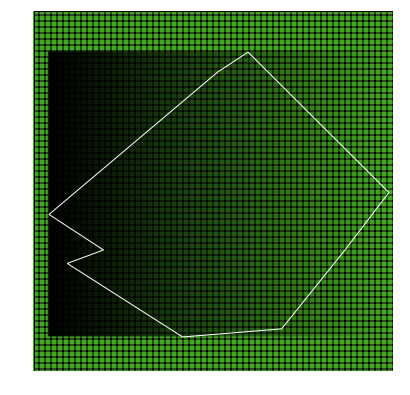

In [29]:
# Generate the background image
#img = get_gradient(500, 500, color, gradient=texture.gradient)
img = get_gradient1(500, 500, color, shape, gradient=texture.gradient)
# Plot the image
fig = plt.figure(frameon=False)
fig.set_size_inches(5, 5)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(
    img,
    interpolation='bicubic'
)
square = Polygon([(0,0), (500, 0), (500, 500), (0, 500)], closed=True, fill=False, color=(0,0,0))
square.set_hatch('++')
ax.add_patch(square)
#add_texture(ax, texture, 500)
boundary = Polygon(shape, closed=True, fill=False, color=(1, 1, 1))
ax.add_patch(boundary)
plt.show()
#plt.savefig('/Users/reubenfeinman/Desktop/fig.png')
#plt.close()

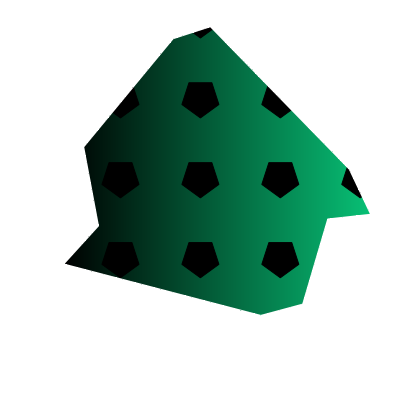

In [367]:
img = image.load_img('/Users/reubenfeinman/Desktop/fig.png', target_size=(500, 500))
img = image.img_to_array(img)
img /= 255.
p = mplpath.Path(shape)
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        if not p.contains_point((i,j)):
            img[j,i,:] = np.array([1.,1.,1.])

fig = plt.figure(frameon=False)
fig.set_size_inches(5, 5)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(img)
plt.show()
#plt.savefig('/Users/reubenfeinman/Desktop/fig_cut.png', bbox_inches='tight')

In [72]:
def generate_dataset_parameters(nb_categories, image_size=500):
    """

    :param nb_shapes:
    :return:
    """
    # Generate shapes, which are sets of points for which polygons will
    # be generated
    shapes = [generate_random_shape(0, 500, 0, 500, 400, 400) for _ in
              range(nb_categories)]
    # Generate colors, which are 3-D vectors of values between 0-1 (RGB values)
    colors = np.random.uniform(0, 1, size=(nb_categories, 3))
    # Generate textures
    patch_types = [
            'ellipse', 'arc', 'arrow', 'circle',
            'rectangle', 'wedge', 'circle_polygon5',
            'circle_polygon6', 'circle_polygon7', 
            'circle_polygon8'
        ]
    nb_variations = int(np.ceil(nb_categories / len(patch_types)))
    textures = []
    for patch_type in patch_types:
        t_list = [generate_texture(patch_type, image_size) for _ in range(nb_variations)]
        textures.extend(t_list)
    textures = np.random.choice(textures, nb_categories, replace=False)

    return shapes, colors, textures

In [73]:
shapes, colors, textures = generate_dataset_parameters(50)

## Color generation

In [7]:
from scipy.spatial.distance import pdist
from itertools import combinations

In [432]:
#best_score = -np.inf
colors = []
scores = []
for _ in range(10000):
    c = np.random.uniform(0, 1, size=(100, 3))
    colors.append(c)
    score = np.min(pdist(c))
    scores.append(score)
#     if score > best_score:
#         colors = c
#         best_score = score

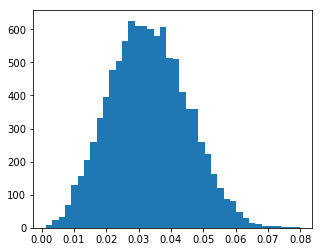

In [437]:
plt.figure(figsize=(5,4))
plt.hist(scores, bins=40)
plt.show()

In [438]:
i_best = np.argmax(scores)
c_best = colors[i_best]
dist_best = pdist(c_best)
i_best_min = np.argmin(dist_best)

i_worst = np.argmin(scores)
c_worst = colors[i_worst]
dist_worst = pdist(c_worst)
i_worst_min = np.argmin(dist_worst)

In [440]:
pairs = list(combinations(range(100), 2))

In [441]:
pair_best = pairs[i_best_min]
pair_worst = pairs[i_worst_min]

In [539]:
def compare_colors(c1, c2):
    fig = plt.figure(frameon=False)
    fig.set_size_inches(5, 5)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    ax.add_patch(Circle((0.25,0.5), 0.1, color=c1))
    ax.add_patch(Circle((0.75,0.5), 0.1, color=c2))
    fig.add_axes(ax)
    plt.show()

0.079828935223


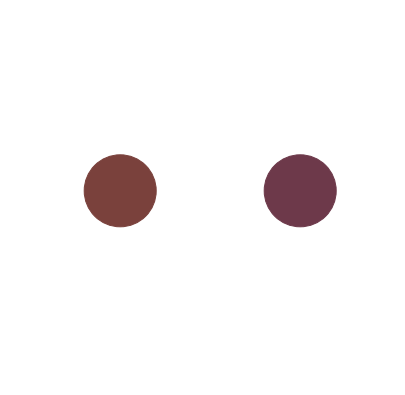

In [540]:
print(np.linalg.norm(c_best[pair_best[0]] - c_best[pair_best[1]]))
compare_colors(c_best[pair_best[0]], c_best[pair_best[1]])

0.00131607863968


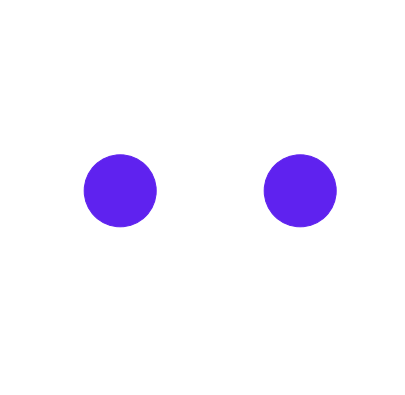

In [443]:
print(np.linalg.norm(c_worst[pair_worst[0]] - c_worst[pair_worst[1]]))
compare_colors(c_worst[pair_worst[0]], c_worst[pair_worst[1]])

In [2]:
def generate_colors(nb_colors):
    """
    Function to generate a set of nb_colors colors. They
    are generated such that there is sufficient distance
    between each color vector. This is better than random
    color sampling.
    :param nb_colors: (int) the number of colors to generate
    :return: (Numpy array) the (nb_colors, 3) color matrix
    """
    nb_bins = np.round(np.power(nb_colors, 1 / 3)) + 1
    vals = np.linspace(0, 0.95, int(nb_bins))
    colors = []
    for r in vals:
        for g in vals:
            for b in vals:
                colors.append([r, g, b])

    colors = sorted(colors, key=lambda x: sum(x))
    colors = colors[-nb_colors:]
    return np.asarray(colors)

In [9]:
colors = generate_colors(10)
dist = pdist(colors)
i_low = np.argmin(dist)
pairs = list(combinations(range(100), 2))
p = pairs[i_low]

In [11]:
np.min(dist)

0.47499999999999998

In [22]:
def show_color(c):
    fig = plt.figure(frameon=False)
    fig.set_size_inches(1, 1)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    ax.add_patch(Circle((0.5,0.5), 0.5, color=c))
    fig.add_axes(ax)
    plt.show()

[ 0.    0.95  0.95]


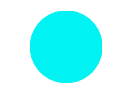

[ 0.475  0.475  0.95 ]


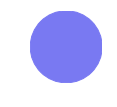

[ 0.475  0.95   0.475]


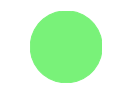

[ 0.95  0.    0.95]


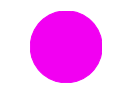

[ 0.95   0.475  0.475]


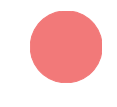

[ 0.95  0.95  0.  ]


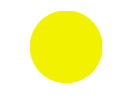

[ 0.475  0.95   0.95 ]


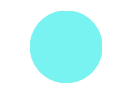

[ 0.95   0.475  0.95 ]


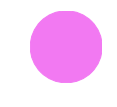

[ 0.95   0.95   0.475]


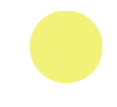

[ 0.95  0.95  0.95]


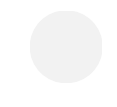

In [23]:
for c in colors:
    print(c)
    show_color(c)

In [25]:
diff = np.asarray([0.95, 0.95, 0.]) - np.asarray([0.95, 0.95, 0.475])
np.linalg.norm(diff)

0.47499999999999998